# Real CR filtering

In [1]:
import pandas as pd

df = pd.read_csv('/home/jovyan/shmelev/CR_agreed/CR_real_masks_more_labeled_veritices_agreed.csv')

In [2]:
df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,1,5,masked,Northen Russians,8.31217,1
1,125,129,masked,Ukranians,8.12189,1
2,171,174,masked,Ukranians,8.01403,1
3,342,343,masked,Southern Russians,8.75644,1
4,379,380,masked,Southern Russians,8.32970,1
...,...,...,...,...,...,...
6802902,64916,110838,Southern Russians,masked,17.68860,1
6802903,64916,200018,Southern Russians,masked,12.17790,1
6802904,227106,84205,Ukranians,masked,9.22315,1
6802905,41192,115611,Northen Russians,masked,8.36391,1


In [3]:
import pandas as pd
import numpy as np

percent = 0.75

# Assuming your DataFrame is called df

# Step 1: Create a mapping from node to label
# Combine both node-label pairs
node_label_map = pd.concat([
    df[['node_id1', 'label_id1']].rename(columns={'node_id1': 'node_id', 'label_id1': 'label_id'}),
    df[['node_id2', 'label_id2']].rename(columns={'node_id2': 'node_id', 'label_id2': 'label_id'})
]).drop_duplicates('node_id')

# Step 2: Find all nodes that are 'masked'
masked_nodes = node_label_map.loc[node_label_map['label_id'] == 'masked', 'node_id']

# Step 3: Randomly sample 50% of masked nodes to remove
np.random.seed(42)  # for reproducibility
nodes_to_remove = np.random.choice(masked_nodes, size=round(len(masked_nodes) * percent), replace=False)

# Step 4: Remove all edges that involve any of those nodes
filtered_df = df[~df['node_id1'].isin(nodes_to_remove) & ~df['node_id2'].isin(nodes_to_remove)]

# Step 5: (Optional) Reset index
filtered_df = filtered_df.reset_index(drop=True)

print(f"Original rows: {len(df)}")
print(f"Filtered rows: {len(filtered_df)}")


Original rows: 6802907
Filtered rows: 1762545


In [4]:
filtered_df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,511,516,masked,Southern Russians,9.00480,1
1,511,518,masked,Southern Russians,8.39013,1
2,748,755,masked,Northen Russians,9.55991,1
3,758,174,masked,Ukranians,9.85806,1
4,758,755,masked,Northen Russians,10.32020,1
...,...,...,...,...,...,...
1762540,142346,180364,masked,Ukranians,9.64378,1
1762541,134680,64916,masked,Southern Russians,8.31714,1
1762542,64916,138932,Southern Russians,masked,9.14168,1
1762543,64916,172790,Southern Russians,masked,8.48938,1


In [5]:
filtered_df.to_csv("/home/jovyan/shmelev/CR_agreed_25_percent_of_masked_nodes/CR_real_masks_more_labeled_veritices_agreed_25_percent_of_masked_nodes.csv", index=False)

# Function for stats printing

In [2]:
# Cell 1 — imports & helpers (STRICT feature detection; folder name is authoritative)
import os, re, json
from dataclasses import dataclass
from typing import Iterable, List, Optional, Tuple, Dict, Any, Set
from datetime import datetime
import numpy as np
import pandas as pd

def _as_list(x) -> Optional[List[str]]:
    if x is None:
        return None
    if isinstance(x, (list, tuple, set)):
        return list(x)
    return [str(x)]

def _matches_substr(name: str, includes: Optional[Iterable[str]]) -> bool:
    """Case-insensitive substring match. If includes is None/empty → True."""
    if not includes:
        return True
    name_l = name.lower()
    return any(p.lower() in name_l for p in includes)

def _parse_date_like(x) -> Optional[datetime]:
    if x is None:
        return None
    if isinstance(x, datetime):
        return x
    for fmt in ("%Y-%m-%d", "%Y-%m-%d %H:%M", "%Y-%m-%d %H:%M:%S"):
        try:
            return datetime.strptime(str(x), fmt)
        except ValueError:
            pass
    raise ValueError(f"Could not parse date '{x}'. Use 'YYYY-MM-DD' (optional time).")

def _get_dir_mtime(path: str) -> datetime:
    return datetime.fromtimestamp(os.path.getmtime(path))

def _infer_model_name_from_dir(dir_name: str) -> str:
    # e.g., "GL_GATConv_3l_512h_split3" -> "GL_GATConv_3l_512h"
    m = re.match(r"(.+?)(?:_?split\d+)?$", dir_name)
    return m.group(1) if m else dir_name

# ------------------------ STRICT feature detection ------------------------
# Boundaries: (?<![a-z0-9]) ... (?![a-z0-9]) to avoid partial matches.
# Order matters: check PLUS before BASE.
_PLUS_PATTERNS = [
    re.compile(r'(?<![a-z0-9])graph[_\- ]?based\+(?![a-z0-9])', re.I),
    re.compile(r'(?<![a-z0-9])graph[_\- ]?based[_\- ]?plus(?![a-z0-9])', re.I),
    re.compile(r'(?<![a-z0-9])gb\+(?![a-z0-9])', re.I),
    re.compile(r'(?<![a-z0-9])gbplus(?![a-z0-9])', re.I),
]
_BASE_PATTERNS = [
    re.compile(r'(?<![a-z0-9])graph[_\- ]?based(?![a-z0-9\+])', re.I),
    re.compile(r'(?<![a-z0-9])graphbased(?![a-z0-9\+])', re.I),
    re.compile(r'(?<![a-z0-9])gb(?![a-z0-9\+])', re.I),
]
_ONEHOT_PATTERNS = [
    re.compile(r'(?<![a-z0-9])one[_\- ]?hot(?![a-z0-9])', re.I),
    re.compile(r'(?<![a-z0-9])onehot(?![a-z0-9])', re.I),
    re.compile(r'(?<![a-z0-9])ohe(?![a-z0-9])', re.I),
]

def _detect_feature_from_dir(dir_name: str) -> Optional[str]:
    """Authoritative feature detection from the model folder name."""
    s = dir_name.lower()
    if any(p.search(s) for p in _PLUS_PATTERNS):
        return "graph_based+"
    if any(p.search(s) for p in _BASE_PATTERNS):
        return "graph_based"
    if any(p.search(s) for p in _ONEHOT_PATTERNS):
        return "one_hot"
    return None

# Canonicalizer for JSON fallbacks
_JSON_TO_CANON = {
    "graph_based+": "graph_based+",
    "graph-based+": "graph_based+",
    "graph based+": "graph_based+",
    "graphbased+": "graph_based+",
    "graph_based_plus": "graph_based+",
    "graph-based-plus": "graph_based+",
    "graph based plus": "graph_based+",
    "graphbasedplus": "graph_based+",

    "graph_based": "graph_based",
    "graph-based": "graph_based",
    "graph based": "graph_based",
    "graphbased": "graph_based",

    "one_hot": "one_hot",
    "one-hot": "one_hot",
    "one hot": "one_hot",
    "onehot": "one_hot",
    "ohe": "one_hot",
}
def _canon_json_token(tok: str) -> Optional[str]:
    return _JSON_TO_CANON.get(tok.strip().lower())

def _feature_tokens_from_json(obj: Dict[str, Any]) -> Optional[Set[str]]:
    """
    JSON fallback. Accepts str, list[str], dicts with 'type'/'name'.
    Returns set of canonical tokens (e.g., {'one_hot'}) or None if nothing usable.
    """
    keys = [
        "feature_type", "features", "feat", "feature",
        "input_features", "input_type", "x_type", "x_features",
        "feature_name", "feature_set"
    ]
    tokens: Set[str] = set()
    seen_any = False
    for k in keys:
        if k not in obj:
            continue
        v = obj[k]; seen_any = True
        if isinstance(v, str):
            c = _canon_json_token(v)
            if c: tokens.add(c)
        elif isinstance(v, (list, tuple)):
            for x in v:
                if isinstance(x, str):
                    c = _canon_json_token(x)
                    if c: tokens.add(c)
        elif isinstance(v, dict):
            for kk in ("type", "name"):
                if kk in v and isinstance(v[kk], str):
                    c = _canon_json_token(v[kk])
                    if c: tokens.add(c)
    if not seen_any or not tokens:
        return None
    return tokens

def _extract_metric_from_json(obj: Dict[str, Any], metric_keys: Tuple[str, ...]) -> Optional[float]:
    # flat
    for k in metric_keys:
        v = obj.get(k)
        if isinstance(v, (int, float)):
            return float(v)
        if isinstance(v, str):
            try:
                return float(v)
            except ValueError:
                pass
    # nested
    for parent in ("test", "eval", "best", "metrics", "test_metrics", "val_metrics"):
        d = obj.get(parent)
        if isinstance(d, dict):
            for k in metric_keys:
                v = d.get(k)
                if isinstance(v, (int, float)):
                    return float(v)
    return None

@dataclass
class MetricRow:
    experiment: str
    dataset: str
    model: str
    feature: str  # "", "graph_based", "graph_based+", "one_hot", or composite like "one_hot|graph_based"
    split_dir: str
    metric: float
    mtime: datetime


In [3]:
# Cell 2 — core scan & summarize (latest experiments enforced; folder-first feature logic)
def collect_metrics(
    runs_root: str,
    include_experiments: Optional[Iterable[str]] = None,
    include_datasets: Optional[Iterable[str]] = None,
    include_models: Optional[Iterable[str]] = None,
    include_features: Optional[Iterable[str]] = None,
    min_date: Optional[str] = None,  # 'YYYY-MM-DD' (optional time)
    metrics_file_candidates: Tuple[str, ...] = ("results.json", "metrics.json"),
    metric_keys: Tuple[str, ...] = ("f1_macro", "f1-macro", "macro_f1"),
) -> List[MetricRow]:
    """
    Walks 'runs_root/<experiment>/<dataset>/<model_per_split>/' and extracts metrics.
    Filters are case-insensitive substrings (no regex).
    Applies a date threshold (min_date) and then *keeps only the latest experiment(s)* overall.
    Feature detection is STRICT and **folder-first** to avoid mixing 'graph_based' with 'graph_based+'.
    """
    include_experiments = _as_list(include_experiments)
    include_datasets    = _as_list(include_datasets)
    include_models      = _as_list(include_models)
    include_features    = _as_list(include_features)
    threshold_dt        = _parse_date_like(min_date)

    # Canonicalize requested features (so 'graph-based+' etc. work if passed)
    inc_feat_tokens: Optional[Set[str]] = None
    if include_features:
        tmp: Set[str] = set()
        for f in include_features:
            c = _canon_json_token(str(f)) or str(f).lower()
            tmp.add(c)
        inc_feat_tokens = tmp

    if not os.path.isdir(runs_root):
        raise FileNotFoundError(f"runs_root not found: {runs_root}")

    rows: List[MetricRow] = []

    for exp in sorted(os.listdir(runs_root)):
        exp_path = os.path.join(runs_root, exp)
        if not os.path.isdir(exp_path) or not _matches_substr(exp, include_experiments):
            continue

        for ds in sorted(os.listdir(exp_path)):
            ds_path = os.path.join(exp_path, ds)
            if not os.path.isdir(ds_path) or not _matches_substr(ds, include_datasets):
                continue

            for split_dir in sorted(os.listdir(ds_path)):
                split_path = os.path.join(ds_path, split_dir)
                if not os.path.isdir(split_path):
                    continue

                # quick prefilter by model tokens in the folder name (helps performance)
                if not _matches_substr(split_dir, include_models):
                    continue

                # pick a metrics file
                metrics_json_path = next(
                    (os.path.join(split_path, cand) for cand in metrics_file_candidates
                     if os.path.isfile(os.path.join(split_path, cand))),
                    None
                )
                if metrics_json_path is None:
                    continue

                try:
                    mtime = datetime.fromtimestamp(os.path.getmtime(metrics_json_path))
                except Exception:
                    mtime = _get_dir_mtime(split_path)
                if threshold_dt and mtime < threshold_dt:
                    continue

                try:
                    with open(metrics_json_path, "r") as f:
                        obj = json.load(f)
                except Exception:
                    continue

                metric_val = _extract_metric_from_json(obj, metric_keys)
                if metric_val is None:
                    continue

                # normalize model name
                model_name = obj.get("model_name") or obj.get("model") or _infer_model_name_from_dir(split_dir)
                if not _matches_substr(model_name, include_models):
                    continue

                # STRICT, folder-first feature detection
                feat_from_dir = _detect_feature_from_dir(split_dir)
                feat_tokens: Optional[Set[str]] = None
                if feat_from_dir:
                    feat_tokens = {feat_from_dir}
                else:
                    feat_tokens = _feature_tokens_from_json(obj)  # fallback ONLY if folder is ambiguous

                # When user requested features, require an intersection
                if inc_feat_tokens is not None:
                    if not feat_tokens:
                        continue
                    if inc_feat_tokens.isdisjoint(feat_tokens):
                        continue

                # Pretty label: sorted tokens joined by '|'
                feature_label = "|".join(sorted(feat_tokens)) if feat_tokens else ""

                rows.append(MetricRow(
                    experiment=exp,
                    dataset=ds,
                    model=model_name,
                    feature=feature_label,
                    split_dir=split_path,
                    metric=float(metric_val),
                    mtime=mtime,
                ))

    if not rows:
        raise RuntimeError("No metrics found after applying filters.")

    # --- keep only the latest experiment(s) overall (ties allowed) ---
    exp_to_latest: Dict[str, datetime] = {}
    for r in rows:
        exp_to_latest[r.experiment] = max(exp_to_latest.get(r.experiment, r.mtime), r.mtime)
    newest_ts = max(exp_to_latest.values())
    newest_exps = {e for e, t in exp_to_latest.items() if t == newest_ts}
    rows = [r for r in rows if r.experiment in newest_exps]

    return rows

def summarize_metrics(
    rows: List[MetricRow],
    expected_splits: Optional[int] = 10,
    strict_expected_splits: bool = True,
) -> pd.DataFrame:
    """
    Aggregate per (Experiment, Dataset, Feature, Model):
    - N (count), Mean, Std.
    If expected_splits is set and strict_expected_splits=True → raise on mismatch.
    """
    if not rows:
        raise ValueError("Empty rows.")

    df = pd.DataFrame([{
        "Experiment": r.experiment,
        "Dataset": r.dataset,
        "Feature": r.feature,
        "Model": r.model,
        "SplitPath": r.split_dir,
        "Metric": r.metric,
        "MTime": r.mtime,
    } for r in rows])

    grp_cols = ["Experiment", "Dataset", "Feature", "Model"]
    out = (
        df.groupby(grp_cols, dropna=False)["Metric"]
          .agg(N="count", Mean="mean", Std="std")
          .reset_index()
    )
    out["Std"] = out["Std"].fillna(0.0)

    if expected_splits is not None and strict_expected_splits:
        bad = out.loc[out["N"] != int(expected_splits)]
        if len(bad):
            lines = "\n".join(
                f"- {row.Experiment} / {row.Dataset} / {row.Feature or '(none)'} / {row.Model}: N={row.N}"
                for row in bad.itertuples(index=False)
            )
            raise ValueError(
                f"Expected {expected_splits} splits per (Experiment, Dataset, Feature, Model). Mismatches:\n{lines}"
            )

    out = out.sort_values(["Dataset", "Mean"], ascending=[True, False]).reset_index(drop=True)
    return out

def summarize_runs(
    runs_root: str,
    include_experiments=None,
    include_datasets=None,
    include_models=None,
    include_features=None,
    min_date: Optional[str] = None,
    metrics_file_candidates: Tuple[str, ...] = ("results.json", "metrics.json"),
    metric_keys: Tuple[str, ...] = ("f1_macro", "f1-macro", "macro_f1"),
    expected_splits: Optional[int] = 10,
    strict_expected_splits: bool = True,
) -> pd.DataFrame:
    rows = collect_metrics(
        runs_root=runs_root,
        include_experiments=include_experiments,
        include_datasets=include_datasets,
        include_models=include_models,
        include_features=include_features,
        min_date=min_date,
        metrics_file_candidates=metrics_file_candidates,
        metric_keys=metric_keys,
    )
    return summarize_metrics(
        rows,
        expected_splits=expected_splits,
        strict_expected_splits=strict_expected_splits,
    )


# Printing stats

### Edge weights

In [8]:
# Cell 3 — configure & run (edit these)
runs_root = "/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs"

# Choose what to include (case-insensitive substrings). None means "no filter".
include_experiments = ["real_data_no_mask"]   # e.g., only experiments whose folder names contain these substrings
include_datasets    = None # ["CR"]           # or None for all
include_models      = ["GL_TAGConv_3l_512h_nw_k3_gnorm"] # ["GL_TAGConv_3l_512h_w_k3_gnorm"]  # or None for all
include_features    = ['one_hot']      # or ["graph_based", "graph_based+"] or None

# Date threshold: include only runs modified on/after this date (optional)
min_date = None #"2025-09-20"  # or None

# Expected number of splits per (Experiment, Dataset, Feature, Model)
expected_splits = 10
strict_expected_splits = True  # see explanation below

df = summarize_runs(
    runs_root=runs_root,
    include_experiments=include_experiments,
    include_datasets=include_datasets,
    include_models=include_models,
    include_features=include_features,
    min_date=min_date,
    expected_splits=expected_splits,
    strict_expected_splits=strict_expected_splits,
)
df  # displays nicely in a Jupyter cell


,Experiment,Dataset,Feature,Model,N,Mean,Std
0,real_data_no_mask,CR,one_hot,GL_TAGConv_3l_512h_nw_k3_gnorm_leaky_relu,10,0.598417,0.017553
1,real_data_no_mask,CR,one_hot,GL_TAGConv_3l_512h_nw_k3_gnorm_relu,10,0.598067,0.020242
2,real_data_no_mask,CR,one_hot,GL_TAGConv_3l_512h_nw_k3_gnorm_gelu,10,0.593917,0.021839
3,real_data_no_mask,CR,one_hot,GL_TAGConv_3l_512h_nw_k3_gnorm,10,0.591654,0.021102
4,real_data_no_mask,NC_graph_rel_eng,one_hot,GL_TAGConv_3l_512h_nw_k3_gnorm_gelu,10,0.934983,0.037967
5,real_data_no_mask,NC_graph_rel_eng,one_hot,GL_TAGConv_3l_512h_nw_k3_gnorm,10,0.931314,0.032405
6,real_data_no_mask,NC_graph_rel_eng,one_hot,GL_TAGConv_3l_512h_nw_k3_gnorm_relu,10,0.925690,0.042262
7,real_data_no_mask,NC_graph_rel_eng,one_hot,GL_TAGConv_3l_512h_nw_k3_gnorm_leaky_relu,10,0.924918,0.042122
8,real_data_no_mask,Scandinavia,one_hot,GL_TAGConv_3l_512h_nw_k3_gnorm,10,0.976567,0.011316
9,real_data_no_mask,Scandinavia,one_hot,GL_TAGConv_3l_512h_nw_k3_gnorm_leaky_relu,10,0.975839,0.015014


### Main picture CR

In [25]:
# Cell 3 — configure & run (edit these)
runs_root = "/home/jovyan/shmelev/GENLINK/downstream_tasks/runs"

# Choose what to include (case-insensitive substrings). None means "no filter".
include_experiments = ["real_data_real_masks"]   # e.g., only experiments whose folder names contain these substrings
include_datasets    = ["CR_real_masks_more_labeled_veritices_agreed"]           # or None for all
include_models      = None # ["GL_TAGConv_3l_512h_w_k3_gnorm"]  # or None for all
include_features    = None      # or ["graph_based", "graph_based+"] or None

# Date threshold: include only runs modified on/after this date (optional)
min_date = None #"2025-09-20"  # or None

# Expected number of splits per (Experiment, Dataset, Feature, Model)
expected_splits = 10
strict_expected_splits = True  # see explanation below

df = summarize_runs(
    runs_root=runs_root,
    include_experiments=include_experiments,
    include_datasets=include_datasets,
    include_models=include_models,
    include_features=include_features,
    min_date=min_date,
    expected_splits=expected_splits,
    strict_expected_splits=strict_expected_splits,
)
df  # displays nicely in a Jupyter cell


,Experiment,Dataset,Feature,Model,N,Mean,Std
0,real_data_real_masks,CR_real_masks_more_labeled_veritices_agreed,graph_based+,GL_TAGConv_3l_512h_w_k3_gnorm,10,0.713525,0.012252
1,real_data_real_masks,CR_real_masks_more_labeled_veritices_agreed,one_hot,GL_TAGConv_3l_512h_w_k3_gnorm,10,0.682513,0.013771
2,real_data_real_masks,CR_real_masks_more_labeled_veritices_agreed,graph_based,GL_MLP_3l_512h,10,0.610162,0.019790
3,real_data_real_masks,CR_real_masks_more_labeled_veritices_agreed,graph_based,GL_TAGConv_3l_512h_w_k3_gnorm,10,0.607583,0.014789
4,real_data_real_masks,CR_real_masks_more_labeled_veritices_agreed,,MaxIbdSumPerClassSize,10,0.588117,0.015077
5,real_data_real_masks,CR_real_masks_more_labeled_veritices_agreed,,MaxEdgeCountPerClassSize,10,0.563480,0.011008
6,real_data_real_masks,CR_real_masks_more_labeled_veritices_agreed,,MaxIbdSum,10,0.530689,0.009321
7,real_data_real_masks,CR_real_masks_more_labeled_veritices_agreed,,MaxSegmentCount,10,0.505366,0.017840
8,real_data_real_masks,CR_real_masks_more_labeled_veritices_agreed,,LongestIbd,10,0.503291,0.019404
9,real_data_real_masks,CR_real_masks_more_labeled_veritices_agreed,,MaxEdgeCount,10,0.480778,0.016030


Saved PDF to: /home/jovyan/shmelev/GENLINK/pictures/cr_unlabeled_linechart.pdf


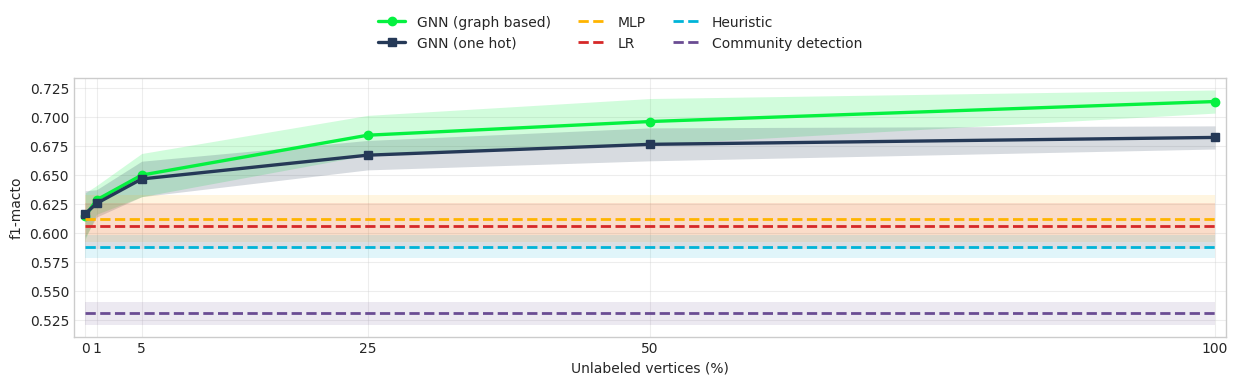

In [18]:
# CR progression chart: baselines (dashed, labeled-only) vs GNNs across real unlabeled shares.
# Changes requested:
# 1) PDF saving option
# 2) Seaborn-like styling and top legend (like your sample)
# 3) y-label is "f1-macto"
# 4) Stretched X axis
# 5) Distinct colors; graph_based+ -> "graph based"; no underscores in labels

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_cr_unlabeled_progression(fig_dir: str = ".", save_pdf: bool = True, save_png: bool = False):
    # ---- Seaborn-like styling (matplotlib built-in) ----
    plt.style.use("seaborn-v0_8-whitegrid")

    # X axis = % of real unlabeled vertices
    x = np.array([0, 1, 5, 25, 50, 100], dtype=float)

    # ---- GNN series (means and stds) ----
    # GNN (one hot)
    gnn_oh_mean = np.array([0.6165, 0.625533, 0.646663, 0.667180, 0.676535, 0.682500], dtype=float)
    gnn_oh_std  = np.array([0.0200,  0.011794, 0.015319, 0.012709, 0.014220, 0.010000], dtype=float)

    # GNN (graph based)  [formerly "graph_based+"]
    gnn_gb_mean = np.array([0.6146, 0.628505, 0.649993, 0.684421, 0.696241, 0.713500], dtype=float)
    gnn_gb_std  = np.array([0.0200,  0.012405, 0.018640, 0.017113, 0.019852, 0.010000], dtype=float)

    # ---- Baselines (from labeled setup; constant across x) ----
    # (mean, std) at 0% unlabeled; drawn as dashed lines across all x
    baselines = {
        "MLP":                 (0.6125, 0.02),
        "LR":                  (0.6059, 0.02),
        "Heuristic":           (0.5881, 0.01),
        "Community detection": (0.5307, 0.01),
    }

    # Distinct palette (hex) similar to your sample
    colors = {
        "GNN (one hot)"     : "#253957",  # deep blue
        "GNN (graph based)" : "#05F140",  # vivid green
        "MLP"               : "#FFB400",  # orange
        "LR"                : "#D62828",  # red
        "Heuristic"         : "#00B4D8",  # cyan
        "Community detection": "#6A4C93", # purple
    }

    # ---- Figure (stretched X axis) ----
    fig, ax = plt.subplots(figsize=(12.5, 3.8))

    # GNN lines (solid) + std bands
    ln_gb, = ax.plot(x, gnn_gb_mean, marker='o', linewidth=2.4, color=colors["GNN (graph based)"], label="GNN (graph based)")
    ax.fill_between(x, gnn_gb_mean - gnn_gb_std, gnn_gb_mean + gnn_gb_std,
                    color=colors["GNN (graph based)"], alpha=0.18, linewidth=0)

    ln_oh, = ax.plot(x, gnn_oh_mean, marker='s', linewidth=2.4, color=colors["GNN (one hot)"], label="GNN (one hot)")
    ax.fill_between(x, gnn_oh_mean - gnn_oh_std, gnn_oh_mean + gnn_oh_std,
                    color=colors["GNN (one hot)"], alpha=0.18, linewidth=0)

    # Baselines (dashed constants) + std bands
    baseline_lines = []
    for name in ["MLP", "LR", "Heuristic", "Community detection"]:
        mean, std = baselines[name]
        y = np.full_like(x, mean, dtype=float)
        ln, = ax.plot(x, y, linestyle='--', linewidth=2.0, color=colors[name], label=name)
        ax.fill_between(x, y - std, y + std, color=colors[name], alpha=0.12, linewidth=0)
        baseline_lines.append(ln)

    # Axes / labels / ticks (no title)
    ax.set_xlabel("Unlabeled vertices (%)")
    ax.set_ylabel("f1-macto")
    ax.set_xticks([0, 1, 5, 25, 50, 100])
    ax.set_xlim(-1, 101)
    ax.grid(True, alpha=0.35)

    # Put legend on top (like your sample)
    handles = [ln_gb, ln_oh] + baseline_lines
    labels  = [h.get_label() for h in handles]
    plt.tight_layout(rect=[0, 0, 1, 0.86])  # leave room for legend
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02),
               ncol=3, frameon=False)

    # Save
    fig_dir = Path(fig_dir)
    fig_dir.mkdir(parents=True, exist_ok=True)
    if save_pdf:
        out_pdf = fig_dir / "cr_unlabeled_linechart.pdf"
        plt.savefig(out_pdf, bbox_inches="tight")
        print(f"Saved PDF to: {out_pdf}")
    if save_png:
        out_png = fig_dir / "cr_unlabeled_linechart.png"
        plt.savefig(out_png, dpi=300, bbox_inches="tight")
        print(f"Saved PNG to: {out_png}")

    plt.show()

# Example:
plot_cr_unlabeled_progression(fig_dir="/home/jovyan/shmelev/GENLINK/pictures", save_pdf=True, save_png=False)

### Other stats

In [4]:
# Cell 3 — configure & run (edit these)
runs_root = "/home/jovyan/shmelev/GENLINK/downstream_tasks/runs"

# Choose what to include (case-insensitive substrings). None means "no filter".
include_experiments = ["real_data_real_masks"]   # e.g., only experiments whose folder names contain these substrings
include_datasets    = ["CR_real_masks_more_labeled_veritices_agreed"]           # or None for all
include_models      = ["GL_TAGConv_3l_512h_w_k3_gnorm"]  # or None for all
include_features    = ["graph_based+"]       # or ["graph_based", "graph_based+"] or None

# Date threshold: include only runs modified on/after this date (optional)
min_date = "2025-09-20"  # or None

# Expected number of splits per (Experiment, Dataset, Feature, Model)
expected_splits = 10
strict_expected_splits = True  # see explanation below

df = summarize_runs(
    runs_root=runs_root,
    include_experiments=include_experiments,
    include_datasets=include_datasets,
    include_models=include_models,
    include_features=include_features,
    min_date=min_date,
    expected_splits=expected_splits,
    strict_expected_splits=strict_expected_splits,
)
df  # displays nicely in a Jupyter cell


,Experiment,Dataset,Feature,Model,N,Mean,Std
0,real_data_real_masks,CR_real_masks_more_labeled_veritices_agreed,graph_based+,GL_TAGConv_3l_512h_w_k3_gnorm,10,0.713525,0.012252


In [10]:
# Cell 3 — configure & run (edit these)
runs_root = "/home/jovyan/shmelev/GENLINK/downstream_tasks/runs"

# Choose what to include (case-insensitive substrings). None means "no filter".
include_experiments = ['real_data_no_mask']   # e.g., only experiments whose folder names contain these substrings
include_datasets    = ["Western-Europe", 'Volga', 'Scandinavia', 'NC_graph_rel_eng', 'CR']           # or None for all
include_models      = None  # or None for all
include_features    = ["graph_based+"]       # or ["graph_based", "graph_based+"] or None

# Date threshold: include only runs modified on/after this date (optional)
min_date = "2025-09-20"  # or None

# Expected number of splits per (Experiment, Dataset, Feature, Model)
expected_splits = 10
strict_expected_splits = True  # see explanation below

df = summarize_runs(
    runs_root=runs_root,
    include_experiments=include_experiments,
    include_datasets=include_datasets,
    include_models=include_models,
    include_features=include_features,
    min_date=min_date,
    expected_splits=expected_splits,
    strict_expected_splits=strict_expected_splits,
)
df  # displays nicely in a Jupyter cell


,Experiment,Dataset,Feature,Model,N,Mean,Std
0,real_data_no_mask,CR,graph_based+,GL_SAGEConv_3l_512h_de,10,0.610937,0.018063
1,real_data_no_mask,CR,graph_based+,GL_SAGEConv_3l_128h_de,10,0.596161,0.018909
2,real_data_no_mask,CR,graph_based+,GL_SAGEConv_9l_512h_de,10,0.589665,0.022290
3,real_data_no_mask,CR,graph_based+,GL_SAGEConv_9l_128h_de,10,0.520383,0.028754
4,real_data_no_mask,NC_graph_rel_eng,graph_based+,GL_SAGEConv_3l_512h_de,10,0.887433,0.065912
5,real_data_no_mask,NC_graph_rel_eng,graph_based+,GL_SAGEConv_9l_512h_de,10,0.873915,0.049113
6,real_data_no_mask,NC_graph_rel_eng,graph_based+,GL_SAGEConv_3l_128h_de,10,0.862811,0.064416
7,real_data_no_mask,NC_graph_rel_eng,graph_based+,GL_SAGEConv_9l_128h_de,10,0.809657,0.056397
8,real_data_no_mask,Scandinavia,graph_based+,GL_SAGEConv_3l_512h_de,10,0.972509,0.011182
9,real_data_no_mask,Scandinavia,graph_based+,GL_SAGEConv_9l_512h_de,10,0.970584,0.013308


In [11]:
# order datasets by their top Mean; within each dataset keep best-to-worst
df["_best_of_ds"] = df.groupby("Dataset")["Mean"].transform("max")
df = (
    df.sort_values(["_best_of_ds", "Dataset", "Mean"],
                   ascending=[False, True, False],
                   kind="mergesort")  # stable: preserves ties consistently
      .drop(columns="_best_of_ds")
      .reset_index(drop=True)
)
df

,Experiment,Dataset,Feature,Model,N,Mean,Std
0,real_data_no_mask,Volga,graph_based+,GL_SAGEConv_3l_128h_de,10,0.987093,0.023514
1,real_data_no_mask,Volga,graph_based+,GL_SAGEConv_3l_512h_de,10,0.984425,0.012918
2,real_data_no_mask,Volga,graph_based+,GL_SAGEConv_9l_512h_de,10,0.967313,0.028956
3,real_data_no_mask,Volga,graph_based+,GL_SAGEConv_9l_128h_de,10,0.910623,0.033099
4,real_data_no_mask,Scandinavia,graph_based+,GL_SAGEConv_3l_512h_de,10,0.972509,0.011182
5,real_data_no_mask,Scandinavia,graph_based+,GL_SAGEConv_9l_512h_de,10,0.970584,0.013308
6,real_data_no_mask,Scandinavia,graph_based+,GL_SAGEConv_3l_128h_de,10,0.969975,0.013755
7,real_data_no_mask,Scandinavia,graph_based+,GL_SAGEConv_9l_128h_de,10,0.966399,0.009589
8,real_data_no_mask,Western-Europe,graph_based+,GL_SAGEConv_3l_128h_de,10,0.946696,0.011057
9,real_data_no_mask,Western-Europe,graph_based+,GL_SAGEConv_3l_512h_de,10,0.944223,0.010138


In [7]:
# Set options to display all rows, columns, and full column width
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000) # Adjust width if columns wrap around


# Cell 3 — configure & run (edit these)
runs_root = "/disk/10tb/home/shmelev/GENLINK/downstream_tasks/runs"

# Choose what to include (case-insensitive substrings). None means "no filter".
include_experiments = ['real_data_mask_100']   # e.g., only experiments whose folder names contain these substrings
include_datasets    = ['CR']           # or None for all
include_models      = None  # or None for all
include_features    = None # ["graph_based+"]       # or ["graph_based", "graph_based+"] or None

# Date threshold: include only runs modified on/after this date (optional)
min_date = None # "2025-09-20"  # or None

# Expected number of splits per (Experiment, Dataset, Feature, Model)
expected_splits = 10
strict_expected_splits = True  # see explanation below

df = summarize_runs(
    runs_root=runs_root,
    include_experiments=include_experiments,
    include_datasets=include_datasets,
    include_models=include_models,
    include_features=include_features,
    min_date=min_date,
    expected_splits=expected_splits,
    strict_expected_splits=strict_expected_splits,
)
df  # displays nicely in a Jupyter cell

# # order datasets by their top Mean; within each dataset keep best-to-worst
# df["_best_of_ds"] = df.groupby("Dataset")["Mean"].transform("max")
# df = (
#     df.sort_values(["_best_of_ds", "Dataset", "Mean"],
#                    ascending=[False, True, False],
#                    kind="mergesort")  # stable: preserves ties consistently
#       .drop(columns="_best_of_ds")
#       .reset_index(drop=True)
# )
# df


,Experiment,Dataset,Feature,Model,N,Mean,Std
0,real_data_mask_100,CR,one_hot,GL_TAGConv_3l_512h_w_k3_gnorm,10,0.583985,0.000000
1,real_data_mask_100,CR,graph_based,GL_TAGConv_9l_128h_w_k3,10,0.580750,0.000000
2,real_data_mask_100,CR,graph_based,GL_TAGConv_9l_512h_w_k3,10,0.556702,0.008711
3,real_data_mask_100,CR,graph_based+,GL_TAGConv_3l_512h_w_k3_gnorm,10,0.552789,0.000000
4,real_data_mask_100,CR,graph_based+,GL_TAGConv_3l_512h_w_k3,10,0.543185,0.000000
5,real_data_mask_100,CR,graph_based+,GL_GINConv_3l_512h,10,0.541865,0.011769
6,real_data_mask_100,CR,one_hot,GL_GINConv_3l_128h,10,0.534623,0.007656
7,real_data_mask_100,CR,one_hot,GL_GINConv_3l_512h,10,0.531995,0.010242
8,real_data_mask_100,CR,graph_based,GL_SAGEConv_9l_128h,10,0.528243,0.000000
9,real_data_mask_100,CR,graph_based+,GL_GINConv_3l_128h,10,0.526170,0.014034


In [13]:
# Cell 3 — configure & run (edit these)
runs_root = "/home/jovyan/shmelev/GENLINK/downstream_tasks/runs"

# Choose what to include (case-insensitive substrings). None means "no filter".
include_experiments = ['real_data_mask_75']   # e.g., only experiments whose folder names contain these substrings
include_datasets    = ['CR']           # or None for all
include_models      = None  # or None for all
include_features    = ["graph_based+"]       # or ["graph_based", "graph_based+"] or None

# Date threshold: include only runs modified on/after this date (optional)
min_date = "2025-09-20"  # or None

# Expected number of splits per (Experiment, Dataset, Feature, Model)
expected_splits = 10
strict_expected_splits = True  # see explanation below

df = summarize_runs(
    runs_root=runs_root,
    include_experiments=include_experiments,
    include_datasets=include_datasets,
    include_models=include_models,
    include_features=include_features,
    min_date=min_date,
    expected_splits=expected_splits,
    strict_expected_splits=strict_expected_splits,
)
df  # displays nicely in a Jupyter cell

# order datasets by their top Mean; within each dataset keep best-to-worst
df["_best_of_ds"] = df.groupby("Dataset")["Mean"].transform("max")
df = (
    df.sort_values(["_best_of_ds", "Dataset", "Mean"],
                   ascending=[False, True, False],
                   kind="mergesort")  # stable: preserves ties consistently
      .drop(columns="_best_of_ds")
      .reset_index(drop=True)
)
df


,Experiment,Dataset,Feature,Model,N,Mean,Std
0,real_data_mask_75,CR,graph_based+,GL_TAGConv_3l_512h_w_k3_gnorm,10,0.530633,0.012975
1,real_data_mask_75,CR,graph_based+,GL_GINConv_3l_512h,10,0.530036,0.012289
2,real_data_mask_75,CR,graph_based+,GL_TAGConv_3l_512h_w_k3,10,0.520720,0.006738
3,real_data_mask_75,CR,graph_based+,GL_GINConv_3l_128h,10,0.519649,0.013341
4,real_data_mask_75,CR,graph_based+,GL_SAGEConv_3l_512h,10,0.495889,0.012655
5,real_data_mask_75,CR,graph_based+,GL_SAGEConv_3l_512h_de,10,0.495259,0.007408
6,real_data_mask_75,CR,graph_based+,GL_SAGEConv_9l_512h,10,0.488033,0.011034
7,real_data_mask_75,CR,graph_based+,GL_SAGEConv_9l_512h_de,10,0.487269,0.009297
8,real_data_mask_75,CR,graph_based+,GL_GATConv_3l_512h,10,0.483406,0.012531
9,real_data_mask_75,CR,graph_based+,GL_SAGEConv_3l_128h,10,0.474731,0.006630


In [14]:
# Cell 3 — configure & run (edit these)
runs_root = "/home/jovyan/shmelev/GENLINK/downstream_tasks/runs"

# Choose what to include (case-insensitive substrings). None means "no filter".
include_experiments = ['real_data_mask_50']   # e.g., only experiments whose folder names contain these substrings
include_datasets    = ['CR']           # or None for all
include_models      = None  # or None for all
include_features    = ["graph_based+"]       # or ["graph_based", "graph_based+"] or None

# Date threshold: include only runs modified on/after this date (optional)
min_date = "2025-09-20"  # or None

# Expected number of splits per (Experiment, Dataset, Feature, Model)
expected_splits = 10
strict_expected_splits = True  # see explanation below

df = summarize_runs(
    runs_root=runs_root,
    include_experiments=include_experiments,
    include_datasets=include_datasets,
    include_models=include_models,
    include_features=include_features,
    min_date=min_date,
    expected_splits=expected_splits,
    strict_expected_splits=strict_expected_splits,
)
df  # displays nicely in a Jupyter cell

# order datasets by their top Mean; within each dataset keep best-to-worst
df["_best_of_ds"] = df.groupby("Dataset")["Mean"].transform("max")
df = (
    df.sort_values(["_best_of_ds", "Dataset", "Mean"],
                   ascending=[False, True, False],
                   kind="mergesort")  # stable: preserves ties consistently
      .drop(columns="_best_of_ds")
      .reset_index(drop=True)
)
df


,Experiment,Dataset,Feature,Model,N,Mean,Std
0,real_data_mask_50,CR,graph_based+,GL_GINConv_3l_512h,10,0.507442,0.007653
1,real_data_mask_50,CR,graph_based+,GL_TAGConv_3l_512h_w_k3,10,0.504588,0.012771
2,real_data_mask_50,CR,graph_based+,GL_TAGConv_3l_512h_w_k3_gnorm,10,0.501404,0.017622
3,real_data_mask_50,CR,graph_based+,GL_GINConv_3l_128h,10,0.498459,0.021480
4,real_data_mask_50,CR,graph_based+,GL_SAGEConv_9l_512h,10,0.482474,0.008558
5,real_data_mask_50,CR,graph_based+,GL_SAGEConv_3l_512h,10,0.479759,0.010830
6,real_data_mask_50,CR,graph_based+,GL_SAGEConv_3l_512h_de,10,0.477524,0.009714
7,real_data_mask_50,CR,graph_based+,GL_SAGEConv_9l_512h_de,10,0.477059,0.010295
8,real_data_mask_50,CR,graph_based+,GL_SAGEConv_3l_128h,10,0.467928,0.007742
9,real_data_mask_50,CR,graph_based+,GL_SAGEConv_3l_128h_de,10,0.466459,0.008457


In [15]:
# Cell 3 — configure & run (edit these)
runs_root = "/home/jovyan/shmelev/GENLINK/downstream_tasks/runs"

# Choose what to include (case-insensitive substrings). None means "no filter".
include_experiments = ['real_data_mask_25']   # e.g., only experiments whose folder names contain these substrings
include_datasets    = ['CR']           # or None for all
include_models      = None  # or None for all
include_features    = ["graph_based+"]       # or ["graph_based", "graph_based+"] or None

# Date threshold: include only runs modified on/after this date (optional)
min_date = "2025-09-20"  # or None

# Expected number of splits per (Experiment, Dataset, Feature, Model)
expected_splits = 10
strict_expected_splits = True  # see explanation below

df = summarize_runs(
    runs_root=runs_root,
    include_experiments=include_experiments,
    include_datasets=include_datasets,
    include_models=include_models,
    include_features=include_features,
    min_date=min_date,
    expected_splits=expected_splits,
    strict_expected_splits=strict_expected_splits,
)
df  # displays nicely in a Jupyter cell

# order datasets by their top Mean; within each dataset keep best-to-worst
df["_best_of_ds"] = df.groupby("Dataset")["Mean"].transform("max")
df = (
    df.sort_values(["_best_of_ds", "Dataset", "Mean"],
                   ascending=[False, True, False],
                   kind="mergesort")  # stable: preserves ties consistently
      .drop(columns="_best_of_ds")
      .reset_index(drop=True)
)
df


,Experiment,Dataset,Feature,Model,N,Mean,Std
0,real_data_mask_25,CR,graph_based+,GL_GINConv_3l_512h,10,0.479879,0.014709
1,real_data_mask_25,CR,graph_based+,GL_TAGConv_3l_512h_w_k3_gnorm,10,0.471472,0.012779
2,real_data_mask_25,CR,graph_based+,GL_TAGConv_3l_512h_w_k3,10,0.470564,0.012608
3,real_data_mask_25,CR,graph_based+,GL_GINConv_3l_128h,10,0.464250,0.021260
4,real_data_mask_25,CR,graph_based+,GL_SAGEConv_3l_512h,10,0.463623,0.011740
5,real_data_mask_25,CR,graph_based+,GL_SAGEConv_3l_512h_de,10,0.460409,0.010973
6,real_data_mask_25,CR,graph_based+,GL_SAGEConv_9l_512h,10,0.451494,0.013049
7,real_data_mask_25,CR,graph_based+,GL_SAGEConv_3l_128h,10,0.448032,0.010266
8,real_data_mask_25,CR,graph_based+,GL_SAGEConv_3l_128h_de,10,0.447689,0.010267
9,real_data_mask_25,CR,graph_based+,GL_TAGConv_3l_128h_w_k3,10,0.444241,0.010216


In [16]:
# Cell 3 — configure & run (edit these)
runs_root = "/home/jovyan/shmelev/GENLINK/downstream_tasks/runs"

# Choose what to include (case-insensitive substrings). None means "no filter".
include_experiments = ['real_data_mask_0']   # e.g., only experiments whose folder names contain these substrings
include_datasets    = ['CR']           # or None for all
include_models      = None  # or None for all
include_features    = ["graph_based+"]       # or ["graph_based", "graph_based+"] or None

# Date threshold: include only runs modified on/after this date (optional)
min_date = "2025-09-20"  # or None

# Expected number of splits per (Experiment, Dataset, Feature, Model)
expected_splits = 10
strict_expected_splits = True  # see explanation below

df = summarize_runs(
    runs_root=runs_root,
    include_experiments=include_experiments,
    include_datasets=include_datasets,
    include_models=include_models,
    include_features=include_features,
    min_date=min_date,
    expected_splits=expected_splits,
    strict_expected_splits=strict_expected_splits,
)
df  # displays nicely in a Jupyter cell

# order datasets by their top Mean; within each dataset keep best-to-worst
df["_best_of_ds"] = df.groupby("Dataset")["Mean"].transform("max")
df = (
    df.sort_values(["_best_of_ds", "Dataset", "Mean"],
                   ascending=[False, True, False],
                   kind="mergesort")  # stable: preserves ties consistently
      .drop(columns="_best_of_ds")
      .reset_index(drop=True)
)
df


,Experiment,Dataset,Feature,Model,N,Mean,Std
0,real_data_mask_0,CR,graph_based+,GL_MLP_3l_512h,10,0.442043,0.000000
1,real_data_mask_0,CR,graph_based+,GL_SAGEConv_3l_512h_de,10,0.439441,0.000000
2,real_data_mask_0,CR,graph_based+,GL_SAGEConv_3l_512h,10,0.434541,0.000000
3,real_data_mask_0,CR,graph_based+,GL_TAGConv_3l_512h_w_k3_gnorm,10,0.413659,0.000000
4,real_data_mask_0,CR,graph_based+,GL_SAGEConv_9l_512h,10,0.411341,0.000000
5,real_data_mask_0,CR,graph_based+,GL_TAGConv_3l_512h_w_k3,10,0.406897,0.000000
6,real_data_mask_0,CR,graph_based+,GL_SAGEConv_3l_128h_de,10,0.405692,0.000000
7,real_data_mask_0,CR,graph_based+,GL_GINConv_3l_512h,10,0.404990,0.006435
8,real_data_mask_0,CR,graph_based+,GL_SAGEConv_3l_128h,10,0.404571,0.000000
9,real_data_mask_0,CR,graph_based+,GL_GATConv_3l_512h,10,0.400482,0.002824
